# Getting started

In this notebook, we illustrate how to use the Neural News Recommendation with Multi-Head Self-Attention ([NRMS](https://aclanthology.org/D19-1671/)). The implementation is taken from the [recommenders](https://github.com/recommenders-team/recommenders) repository. We have simply stripped the model to keep it cleaner.

We use a small dataset, which is downloaded from [recsys.eb.dk](https://recsys.eb.dk/). All the datasets are stored in the folder path ```~/ebnerd_data/*```.

In [1]:
import torch
import torch.nn as nn
epoch = 0
num_epochs = 10
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

>> Using device: cuda:0


## Load functionality

In [2]:
from transformers import AutoTokenizer, AutoModel
from pathlib import Path
import tensorflow as tf
import polars as pl
from torch.utils.tensorboard import SummaryWriter


from _constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
)

from _behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)
from _articles import convert_text2encoding_with_transformers
from _polars import concat_str_columns, slice_join_dataframes
from _articles import create_article_id_to_value_mapping
from _nlp import get_transformers_word_embeddings
from _python import write_submission_file, rank_predictions_by_score

from dataloader import NRMSDataLoader
from model_config import hparams_nrms
from NRMSModel import NRMSModel

c:\Users\danie\anaconda3\envs\DeepLearningNew\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [3]:
def get_parameters():
    learning_rate = float(input("Learning rate: "))
    batch_size = int(input("Batch size: "))
    epochs = int(input("Epochs: "))
    weight_decay = float(input("Weight decay: "))
    head_dim = int(input("Head dimension/number: "))
    history_size = int(input("History size: "))
    
    return learning_rate, batch_size, epochs, weight_decay, head_dim, history_size

learning_rate, batch_size, epochs, weight_decay, head_dim, history_size = get_parameters()
hparams_nrms.learning_rate = learning_rate
hparams_nrms.batch_size = batch_size
hparams_nrms.epochs = epochs
hparams_nrms.weight_decay = weight_decay
hparams_nrms.head_dim = head_dim
hparams_nrms.head_num = head_dim
hparams_nrms.history_size = history_size

def ebnerd_from_path(path: Path, history_size: int = 10) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

### Generate labels
We sample a few just to get started. For testset we just make up a dummy column with 0 and 1 - this is not the true labels.

In [4]:
PATH = Path("~/ebnerd_data").expanduser()
DATASPLIT = "ebnerd_small"
DUMP_DIR = PATH.joinpath("downloads1")
DUMP_DIR.mkdir(exist_ok=True, parents=True)

In this example we sample the dataset, just to keep it smaller. Also, one can simply add the testset similary to the validation.

In [5]:
COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
]
HISTORY_SIZE = hparams_nrms.history_size
FRACTION = 0.01

df_train = (
    ebnerd_from_path(PATH.joinpath(DATASPLIT, "train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath(DATASPLIT, "validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
df_train.head(2)

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,labels
u32,list[i32],list[i64],list[i64],u32,list[i8]
15545,"[9770594, 9770882, … 9770538]","[9776497, 9776715, … 9776046]",[9776046],5939154,"[0, 0, … 1]"
62209,"[9767399, 9767301, … 9767620]","[9776040, 9533957, … 9776489]",[9776489],363197960,"[0, 0, … 1]"


## Load articles

In [6]:
df_articles = pl.read_parquet(PATH.joinpath("ebnerd_small/articles.parquet"))
df_articles.head(2)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3001353,"""Natascha var i…","""Politiet frygt…",2023-06-29 06:20:33,false,"""Sagen om den ø…",2006-08-31 08:06:45,[3150850],"""article_defaul…","""https://ekstra…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative"""
3003065,"""Kun Star Wars …","""Biografgængern…",2023-06-29 06:20:35,false,"""Vatikanet har …",2006-05-21 16:57:00,[3006712],"""article_defaul…","""https://ekstra…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive"""


## Init model using HuggingFace's tokenizer and wordembedding
In the original implementation, they use the GloVe embeddings and tokenizer. To get going fast, we'll use a multilingual LLM from Hugging Face. 
Utilizing the tokenizer to tokenize the articles and the word-embedding to init NRMS.


In [7]:
TRANSFORMER_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
TEXT_COLUMNS_TO_USE = [DEFAULT_SUBTITLE_COL, DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# We'll init the word embeddings using the
word2vec_embedding = get_transformers_word_embeddings(transformer_model)
print(word2vec_embedding.shape)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)

c:\Users\danie\anaconda3\envs\DeepLearningNew\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\danie\anaconda3\envs\DeepLearningNew\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(250037, 384)


# Initiate the dataloaders
In the implementations we have disconnected the models and data. Hence, you should built a dataloader that fits your needs.

In [8]:
train_dataloader = NRMSDataLoader(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
    batch_size=hparams_nrms.batch_size,
)
val_dataloader = NRMSDataLoader(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
    batch_size=hparams_nrms.batch_size,
)

In [9]:
def print_hparams(hparams):
    print("Hyperparameters:")
    print(f"Learning rate: {hparams.learning_rate}")
    print(f"Batch size: {hparams.batch_size}")
    print(f"Epochs: {hparams.epochs}")
    print(f"Weight decay: {hparams.weight_decay}")
    print(f"Head dimension: {hparams.head_dim}")
    print(f"Head number: {hparams.head_num}")
    
        
print_hparams(hparams_nrms)

Hyperparameters:
Learning rate: 0.001
Batch size: 8
Epochs: 10
Weight decay: 1e-06
Head dimension: 8
Head number: 8


## Train the model


In [ ]:
from sklearn.metrics import roc_auc_score
import torch.nn.utils  # Ensure this is imported for gradient clipping

epoch = 0
num_epochs = hparams_nrms.epochs

word2vec_embedding = torch.tensor(word2vec_embedding, dtype=torch.float32).to(device)

nrms = NRMSModel(hparams_nrms=hparams_nrms, word2vec_embedding=word2vec_embedding, seed=50).to(device)  # Adding to device
print(nrms)

for name, param in nrms.named_parameters():
    print(f"Parameter: {name}, Requires Grad: {param.requires_grad}, Shape: {param.shape}")


optimizer = torch.optim.Adam(nrms.parameters(), lr=hparams_nrms.learning_rate, weight_decay=hparams_nrms.weight_decay)
loss_fn = nn.CrossEntropyLoss()
val_loss_fn = nn.CrossEntropyLoss()

# Gradient clipping parameter
max_norm = 5.0  # Maximum gradient norm

# Training loop
for epoch in range(num_epochs):
    nrms.train()  # Set the model to training mode
    running_loss = 0.0
    all_labels = []
    all_outputs = []
    running_losses = []
    
    for i, ((his_input_title, pred_input_title), labels) in enumerate(train_dataloader):
        his_input_title = his_input_title.to(device, dtype=torch.long)
        pred_input_title = pred_input_title.to(device, dtype=torch.long)
        og_labels = labels
        labels = labels.to(device, dtype=torch.long).view(-1)

        optimizer.zero_grad()  # Zero the gradients
        outputs = nrms(his_input_title, pred_input_title).to(device)  # Forward pass
        
        loss = loss_fn(outputs.view(-1), labels.float())  # Compute the loss
        loss.backward()  # Backward pass
        loss.detach()  # Detach the loss to save memory
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(nrms.parameters(), max_norm)

        optimizer.step()  # Update the parameters
        running_loss += loss.item()
        running_losses.append(loss.item())
    
        
        # Detach tensors immediately after use to save memory
        his_input_title.detach()
        pred_input_title.detach()
        labels.detach()
        
        # Save labels and outputs for AUC calculation
        all_labels.extend(og_labels.detach().cpu().numpy())
        all_outputs.extend(outputs.detach().cpu().numpy())
        
        del his_input_title, pred_input_title, labels, loss, outputs, og_labels
        torch.cuda.empty_cache()  # Clear unused GPU memory

    # Calculate AUC score
    auc = 0
    for i, label_true in enumerate(all_labels):
        auc += roc_auc_score(label_true, all_outputs[i])
    auc /= len(all_labels)
    
    # Print training details
    print(f"Epoch: {epoch + 1}/{num_epochs}")
    print(f"Training loss: {running_loss:.10f}, Training AUC: {auc:.10f}")
    # print(f"Training outputs: {all_outputs[:10]}")
    # print(f"Training labels: {all_labels[:10]}")

    # Validation loop
    nrms.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []
    val_loss = 0.0
    validation_losses = []
    with torch.no_grad():
        for i, ((his_input_title, pred_input_title), labels) in enumerate(val_dataloader):
            his_input_title = his_input_title.to(device, dtype=torch.long)
            pred_input_title = pred_input_title.to(device, dtype=torch.long)
            og_labels = labels
            labels = labels.to(device, dtype=torch.long).view(-1)

            outputs = nrms(his_input_title, pred_input_title).to(device)  # Forward pass
            loss = val_loss_fn(outputs.view(-1), labels.float())
            val_loss = loss.item()
            validation_losses.append(loss.item())

            all_labels.extend(og_labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())
            
            # Detach tensors immediately after use to save memory
            his_input_title = his_input_title.detach()
            pred_input_title = pred_input_title.detach()
            labels = labels.detach()
            outputs = outputs.detach()
            del his_input_title, pred_input_title, labels, outputs
            torch.cuda.empty_cache()
            
    # Calculate AUC score
    auc = roc_auc_score(all_labels, all_outputs)
    
    # print(f"Validation outputs: {all_outputs[:10]}")
    # print(f"Validation labels: {all_labels[:10]}")
    
    # Print validation details
    print(f"Validation loss: {val_loss:.10f}, Validation AUC: {auc:.10f}")
    print(f"--------------------------\n")
        

# Save the model
torch.save(nrms.state_dict(), "nrms_model.pth")
print("Model saved!")

        



NRMSModel(
  (embedding): Embedding(250037, 384)
  (encode_news): NewsEncoder(
    (embedding): Embedding(250037, 384)
    (dropout): Dropout(p=0.2, inplace=False)
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (attention): AttLayer2()
  )
  (user_encoder): UserEncoder(
    (multihead_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
    )
    (additive_attention): AttLayer2()
    (dropout): Dropout(p=0.2, inplace=False)
    (batch_norm_attention): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Parameter: embedding.weight, Requires Grad: False, Shape: torch.Size([250037, 384])
Parameter: encode_news.embedding.weight, Requires Grad: False, Shape: torch.Size([250037, 384])
Parameter: encode_news.multihead_attention.in_proj_weight, Requires Grad: True, Shape: torch.Siz

AttributeError: 'float' object has no attribute 'shape'

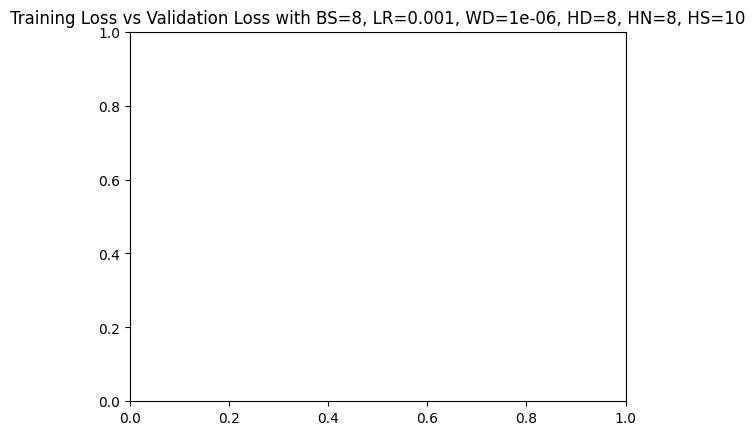

In [ ]:
# Plot the training loss and validation loss
import matplotlib.pyplot as plt

plt.title(f"Training Loss vs Validation Loss with BS={hparams_nrms.batch_size}, LR={hparams_nrms.learning_rate}, WD={hparams_nrms.weight_decay}, HD={hparams_nrms.head_dim}, HN={hparams_nrms.head_num}, HS={hparams_nrms.history_size}")
plt.plot(range(1, num_epochs + 1), running_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs + 1), validation_losses, label="Validation Loss")
plt.legend()
plt.show()
plt.savefig(f"loss_bs{hparams_nrms.batch_size}_lr{hparams_nrms.learning_rate}_wd{hparams_nrms.weight_decay}_hd{hparams_nrms.head_dim}_hn{hparams_nrms.head_num}_hs{hparams_nrms.history_size}.png")

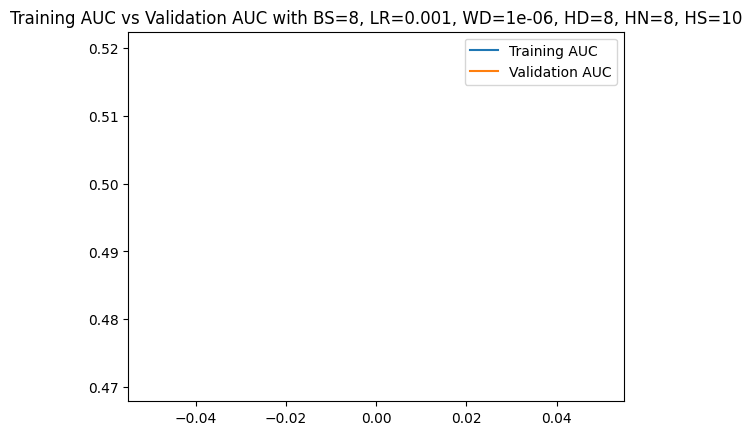

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot the training AUC and validation AUC
plt.title(f"Training AUC vs Validation AUC with BS={hparams_nrms.batch_size}, LR={hparams_nrms.learning_rate}, WD={hparams_nrms.weight_decay}, HD={hparams_nrms.head_dim}, HN={hparams_nrms.head_num}, HS={hparams_nrms.history_size}")
plt.plot(auc, label="Training AUC")
plt.plot(auc, label="Validation AUC")
plt.legend()
plt.show()
plt.savefig(f"auc_bs{hparams_nrms.batch_size}_lr{hparams_nrms.learning_rate}_wd{hparams_nrms.weight_decay}_hd{hparams_nrms.head_dim}_hn{hparams_nrms.head_num}_hs{hparams_nrms.history_size}.png")

In [13]:
# Load the model
nrms = NRMSModel(hparams_nrms=hparams_nrms, word2vec_embedding=word2vec_embedding, seed=50).to(device)
nrms.load_state_dict(torch.load("nrms_model.pth"))
nrms.eval()

# Generate predictions
predictions = []
nrms.eval()
with torch.no_grad():
    for i, ((his_input_title, pred_input_title), labels) in enumerate(val_dataloader):
        his_input_title = his_input_title.to(device, dtype=torch.long)
        pred_input_title = pred_input_title.to(device, dtype=torch.long)
        outputs = nrms(his_input_title, pred_input_title).to(device)
        predictions.extend(outputs.cpu().numpy())
        his_input_title = his_input_title.detach()
        pred_input_title = pred_input_title.detach()
        outputs = outputs.detach()
        del his_input_title, pred_input_title, outputs
        torch.cuda.empty_cache()
        
# Rank the predictions
df_validation = df_validation.with_column("predictions", pl.Series(predictions))
df_validation = rank_predictions_by_score(df_validation, "predictions", groupby=DEFAULT_IMPRESSION_ID_COL)
df_validation.head(5)


C:\Users\danie\AppData\Local\Temp\ipykernel_20048\1362560733.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nrms.load_state_dict(torch.load("nrms_model.pth"))


AttributeError: 'DataFrame' object has no attribute 'with_column'

# Example how to compute some metrics:

In [ ]:
# pred_validation = model.scorer.predict(val_dataloader)

## Add the predictions to the dataframe

In [ ]:
# df_validation = add_prediction_scores(df_validation, pred_validation.tolist()).pipe(
#     add_known_user_column, known_users=df_train[DEFAULT_USER_COL]
# )
# df_validation.head(2)

### Compute metrics

In [ ]:
# metrics = MetricEvaluator(
#     labels=df_validation["labels"].to_list(),
#     predictions=df_validation["scores"].to_list(),
#     metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
# )
# metrics.evaluate()

## Make submission file

In [ ]:
# df_validation = df_validation.with_columns(
#     pl.col("scores")
#     .map_elements(lambda x: list(rank_predictions_by_score(x)))
#     .alias("ranked_scores")
# )
# df_validation.head(2)

This is using the validation, simply add the testset to your flow.

In [ ]:
# write_submission_file(
#     impression_ids=df_validation[DEFAULT_IMPRESSION_ID_COL],
#     prediction_scores=df_validation["ranked_scores"],
#     path="downloads/predictions.txt",
# )

# DONE 🚀